# Test cubic spline to boundary artifact of SDE

## Defining function

In [1]:
# Liberary
import numpy as np
from scipy.interpolate import CubicSpline
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

In [2]:
# Sympy function
import sympy
#sympy.init_printing()
z = sympy.symbols('z')

K0 = 1e-6
K1 = 6e-3  # m / s
Aalpha = 0.5
c = 20
w = 0

sym_Diffu = K0 + K1 * z * sympy.exp(-Aalpha * z)  #*(sympy.tanh(c*(z+0.05)))
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu = sympy.utilities.lambdify(z, sym_Diffu, np)
dKdz = sympy.utilities.lambdify(z, sym_dKdz, np)
Beta = sympy.utilities.lambdify(z, sym_Beta, np)
dBdz = sympy.utilities.lambdify(z, sym_dBdz, np)
ddBdzz = sympy.utilities.lambdify(z, sym_ddBdzz, np)
Alpha = sympy.utilities.lambdify(z, sym_Alpha, np)
dAdz = sympy.utilities.lambdify(z, sym_dAdz, np)
ddAdzz = sympy.utilities.lambdify(z, sym_ddAdzz, np)
dABdz = sympy.utilities.lambdify(z, sym_Alpha * sym_Beta, np)

In [3]:
# SDE schemes
# Euler-Maruyama

def step_e(z, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)

    a = dKdz(z)
    b = np.sqrt(2 * Diffu(z))

    temp = z + a * dt + b * dW

    return temp
def step_e_const(z, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    K0 = 3e-3
    b = np.sqrt(2 * K0)

    temp = z + b * dW
    return temp
# Visser
def step_v(z, H, dt, N_sample):

    dW = np.random.uniform(-1, 1, N_sample)
    r = 1 / 3
    #dW=np.random.normal(0,np.sqrt(dt),N_sample)
    #r=dt

    a = dKdz(z)
    G = Diffu(z + a * dt / 2)

    temp = z + a * dt + np.sqrt(2 / r * dt * G) * dW
    return temp
def step_v_const(z, H, dt, N_sample):
    K0 = 3e-3

    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3

    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    r = dt

    temp = z + np.sqrt(2 / r * dt * K0) * dW
    return temp
# Milstein
def step_m(z, H, dt, N_sample):
    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    #de=np.random.normal(dt,np.sqrt(dt),N_sample)
    #temp= z + (1/2)*dKdz(z)*(de+dt) + Beta(z)*dW

    temp = z + (1 / 2) * dKdz(z) * (dW * dW + dt) + Beta(z) * dW
    return temp
# Milstein 2 nd
def step_m2(z, H, dt, N_sample):
    dW = np.random.normal(0, np.sqrt(dt), N_sample)

    k = Diffu(z)
    dkdz = dKdz(z)
    ddkdz = dAdz(z)
    dddkdz = ddAdzz(z)
    sqrt2k = np.sqrt(2 * k)

    a = dkdz
    da = ddkdz
    dda = dddkdz
    b = sqrt2k
    db = dkdz / b
    ddb = ddkdz / b - ((dkdz)**2) / b**3
    ab = da * b + a * db

    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2

    return temp

In [4]:
# Parallel functions

def oneStep2(Z ,scheme, H, dt, PDF):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (0 > Z)) 
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel2(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand,
             scheme):

    np.random.seed()
    Ntime = int(Tmax / dt)

    hist_ = np.zeros((Nbins - 1, ), 'uint64')
    hist_Cross = np.zeros((Nbins - 1, ), 'uint64')
    hist_Land = np.zeros((Nbins - 1, ), 'uint64')

    z = np.linspace(0, H, int(Np))
    #z = np.random.uniform(0, H, int(Np))

    temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
    hist_ = hist_ + temp0
    
    for i in range(Ntime):

        z, Cross, Land = oneStep2(z, scheme, H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0

        temp2, _ = np.histogram(Cross, bins=np.linspace(0, Testdepth, Nbins))
        hist_Cross = hist_Cross + temp2

        temp3, _ = np.histogram(Land, bins=np.linspace(0, Testdepth, Nbins))
        hist_Land = hist_Land + temp3
        
        try:
            if (i % int(Ntime / 100) == 0):
                print("\r %6.2f" % (i * 100 / Ntime + 1),
                      "%",
                      end="\r",
                      flush=True)
        except ZeroDivisionError as err:
            None
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)

    return None

def RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp = np.full((NumberOfThread, ), int(Np / NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np % NumberOfThread)
    
    Ntime = int(Tmax / dt)  #Number of time interval

    if (__name__ == '__main__'):

        threads = []
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target=parallel2,
                                args=(Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                      quene, queneCross, queneLand, scheme))

            threads.append(thread)
            thread.start()  #starting calculation.

        for thread in threads:
            thread.join()  #waiting these processes finish.

    hist_ = np.zeros((Nbins - 1, ), 'float64')
    hist_Cross = np.zeros((Nbins - 1, ), 'float64')
    hist_Land = np.zeros((Nbins - 1, ), 'float64')

    for i in range(NumberOfThread):
        hist_ += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()
        
    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_*H) / (Np * dz * (Ntime+1))

    lists = []
    lists.append(hist_)

    lists_2 = []
    lists_2.append(hist_Cross)

    lists_3 = []
    lists_3.append(hist_Land)

    return hist_, hist_Cross, hist_Land

In [5]:
# Parallel functions

def oneStep(Z, scheme, H, dt):

    Z = scheme(Z, H, dt, Z.size)

    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2 * H - Z, Z)

    return Z

def parallel(Tmax, dt, H, Testdepth, Np, Nbins, quene, scheme):

    np.random.seed()
    Ntime = int(Tmax / dt)

    hist_ = np.zeros((Nbins - 1, ), 'uint64')

    z = np.linspace(0, H, int(Np))
    #z = np.random.uniform(0, H, int(Np))

    temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
    hist_ = hist_ + temp0

    for i in range(Ntime):

        z = oneStep(z, scheme, H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0

        try:
            if (i % int(Ntime / 100) == 0):
                print("\r %6.2f" % (i * 100 / Ntime + 1),
                      "%",
                      end="\r",
                      flush=True)
        except ZeroDivisionError as err:
            None

    quene.put(hist_)

    return None

def RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp = np.full((NumberOfThread, ), int(Np / NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np % NumberOfThread)

    Ntime = int(Tmax / dt)  #Number of time interval

    if (__name__ == '__main__'):

        threads = []
        quene = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target=parallel,
                                args=(Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                      quene, scheme))

            threads.append(thread)
            thread.start()  #starting calculation.

        for thread in threads:
            thread.join()  #waiting these processes finish.

    hist_ = np.zeros((Nbins - 1, ), 'float64')

    for i in range(NumberOfThread):
        hist_ += quene.get()

    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_ * H) / (Np * dz * (Ntime + 1))

    return hist_

### Creating Spline

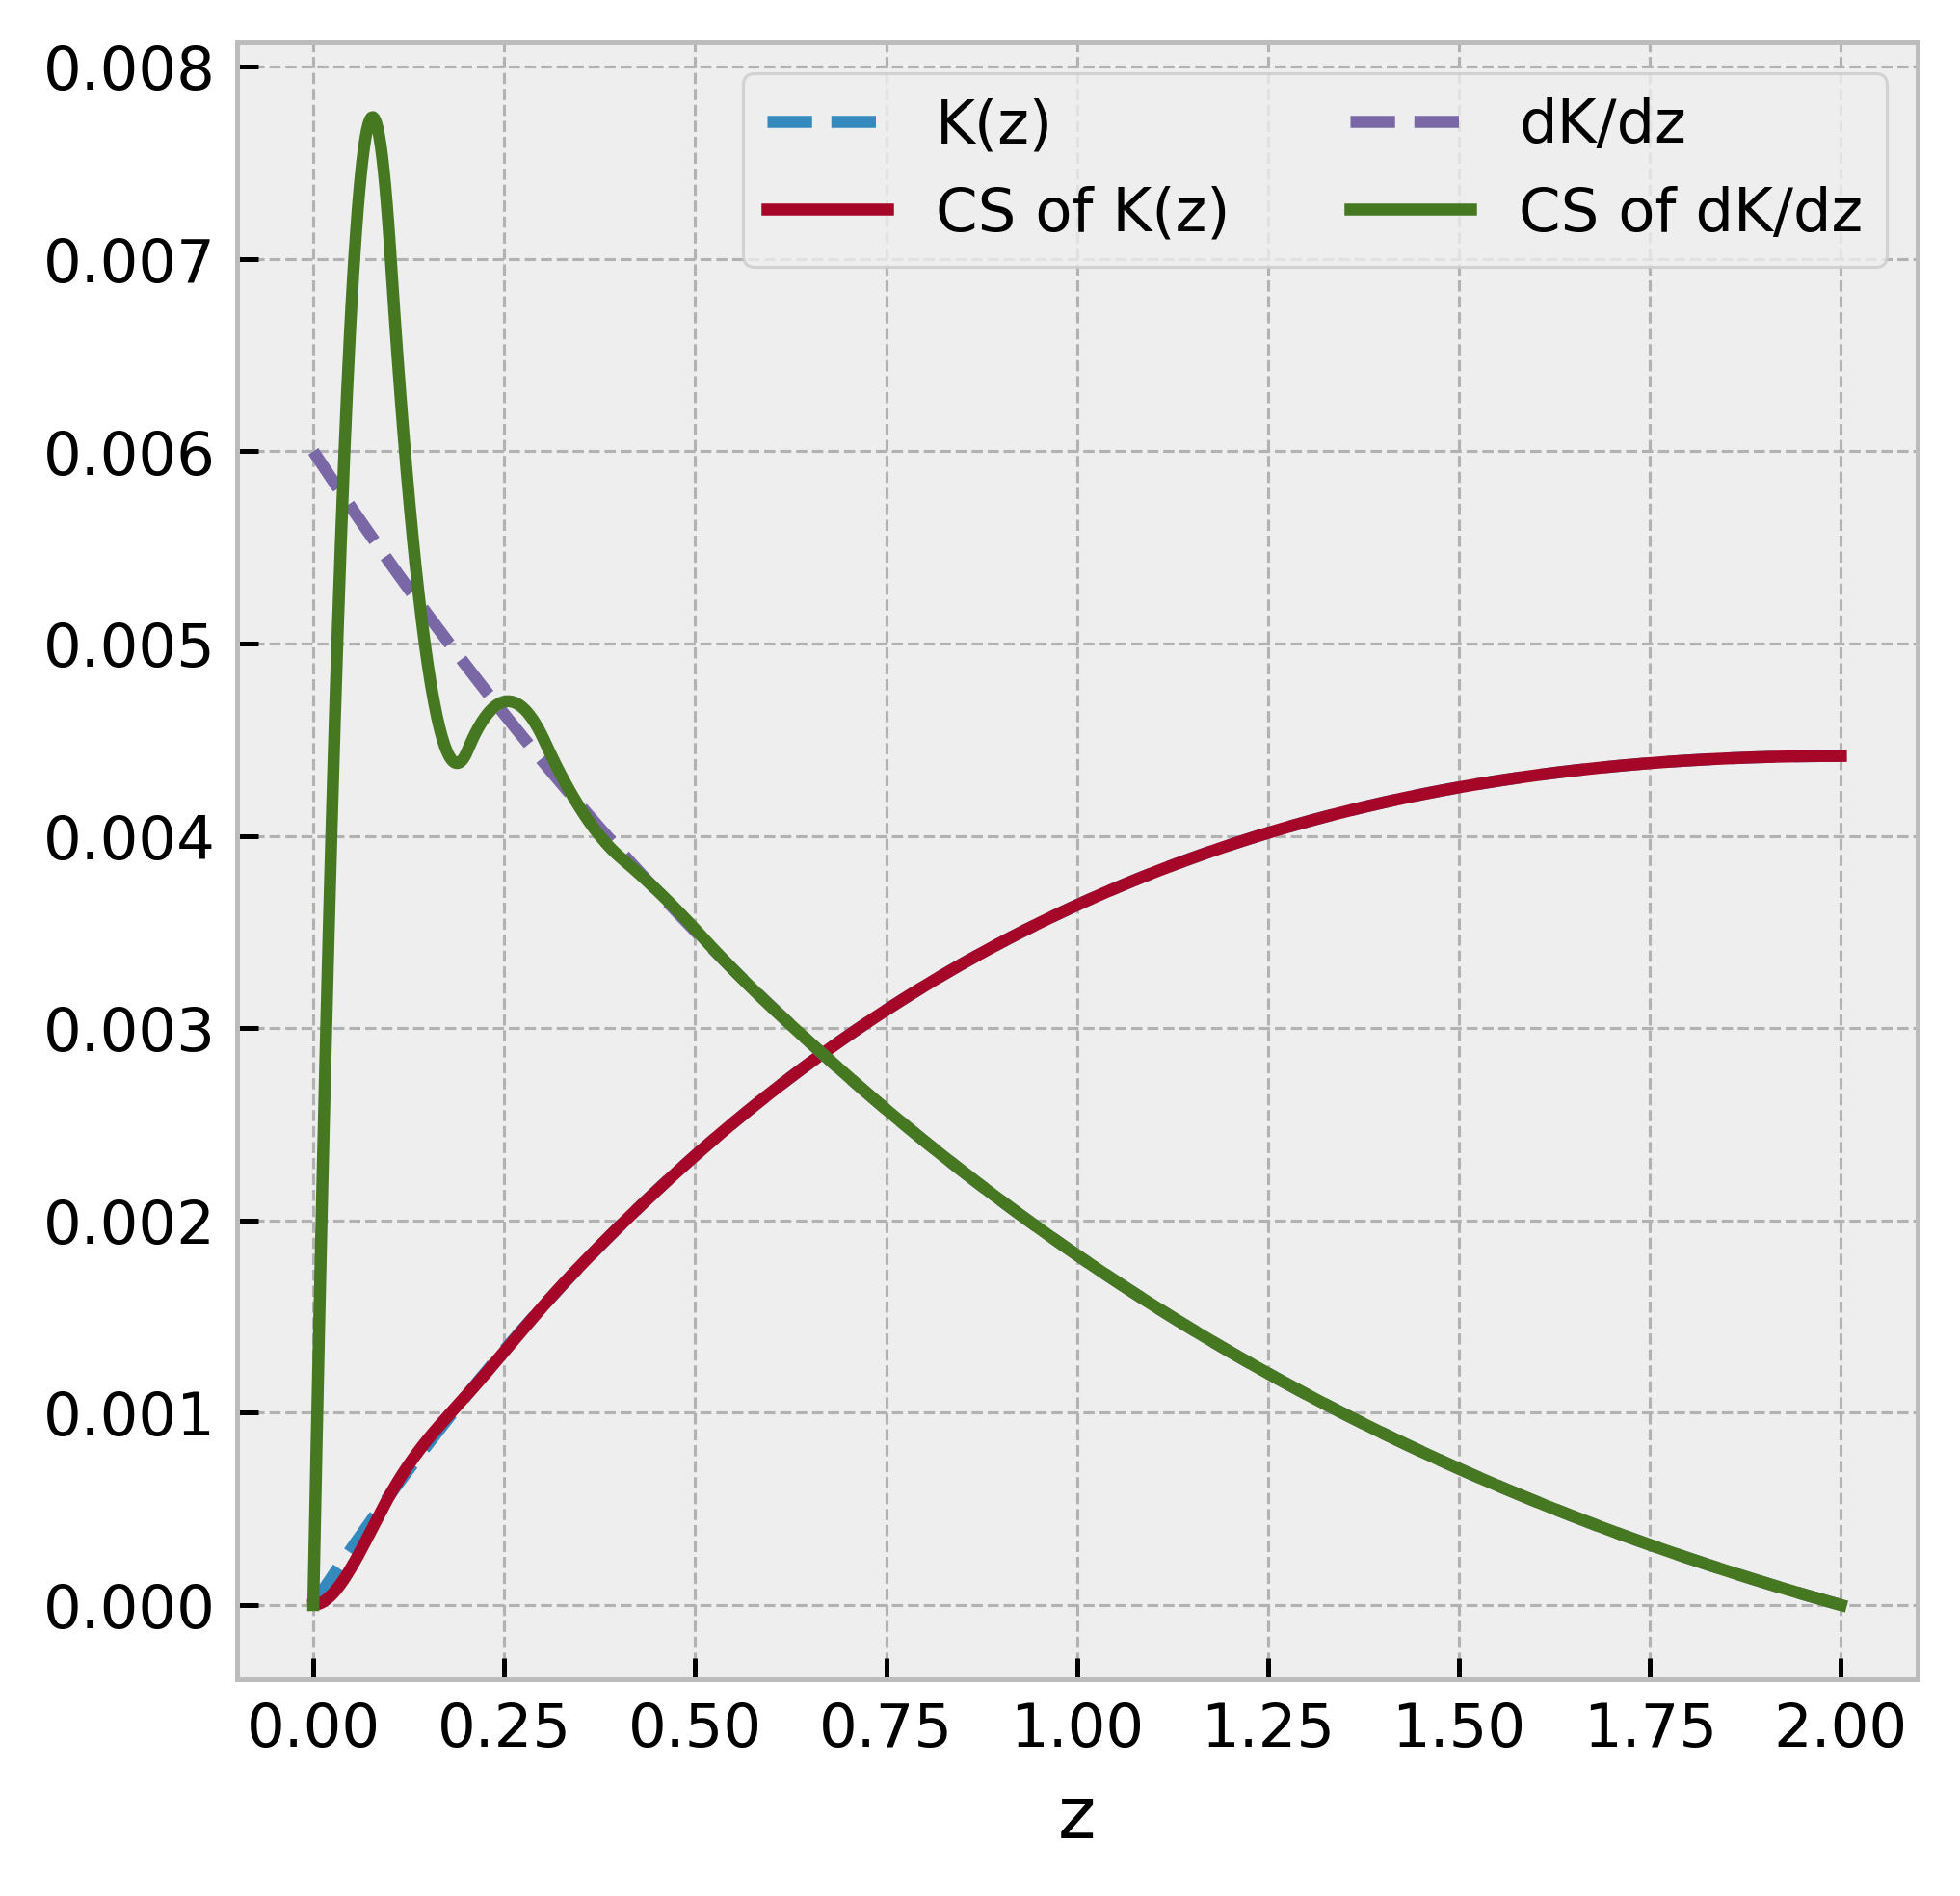

5.005752881503436


In [6]:
# Making spline and their function

%matplotlib inline
x = np.linspace(0, 10, 100)

delete = 0
for i in range(delete):
    x = np.delete(x, 1)
y = Diffu(x)

y[0] = K0

cs = CubicSpline(x, y, bc_type = "clamped", extrapolate= True)
xs = np.linspace(0, 2, 1000)

plt.figure( figsize=(5, 5) , dpi = 450)
plt.plot(xs, Diffu(xs), "--", label='K(z)')
plt.plot(xs, cs(xs), label="CS of K(z)")
plt.plot(xs, dKdz(xs),  "--", label="dK/dz")
plt.plot(xs, cs(xs, 1), label="CS of dK/dz")
#plt.plot(xs, cs(xs, 2), label="S''")
#plt.plot(xs, cs(xs, 3), label="S'''")
#plt.xlim(-0.001, 10)
plt.xlabel("z")
plt.legend(ncol=2)
#plt.xlim(0, 0.00005)
#plt.ylim(-0.0000003, 0.000002)
plt.show()

temp = np.absolute(cs(xs,2))
print(1/(np.max(temp)))

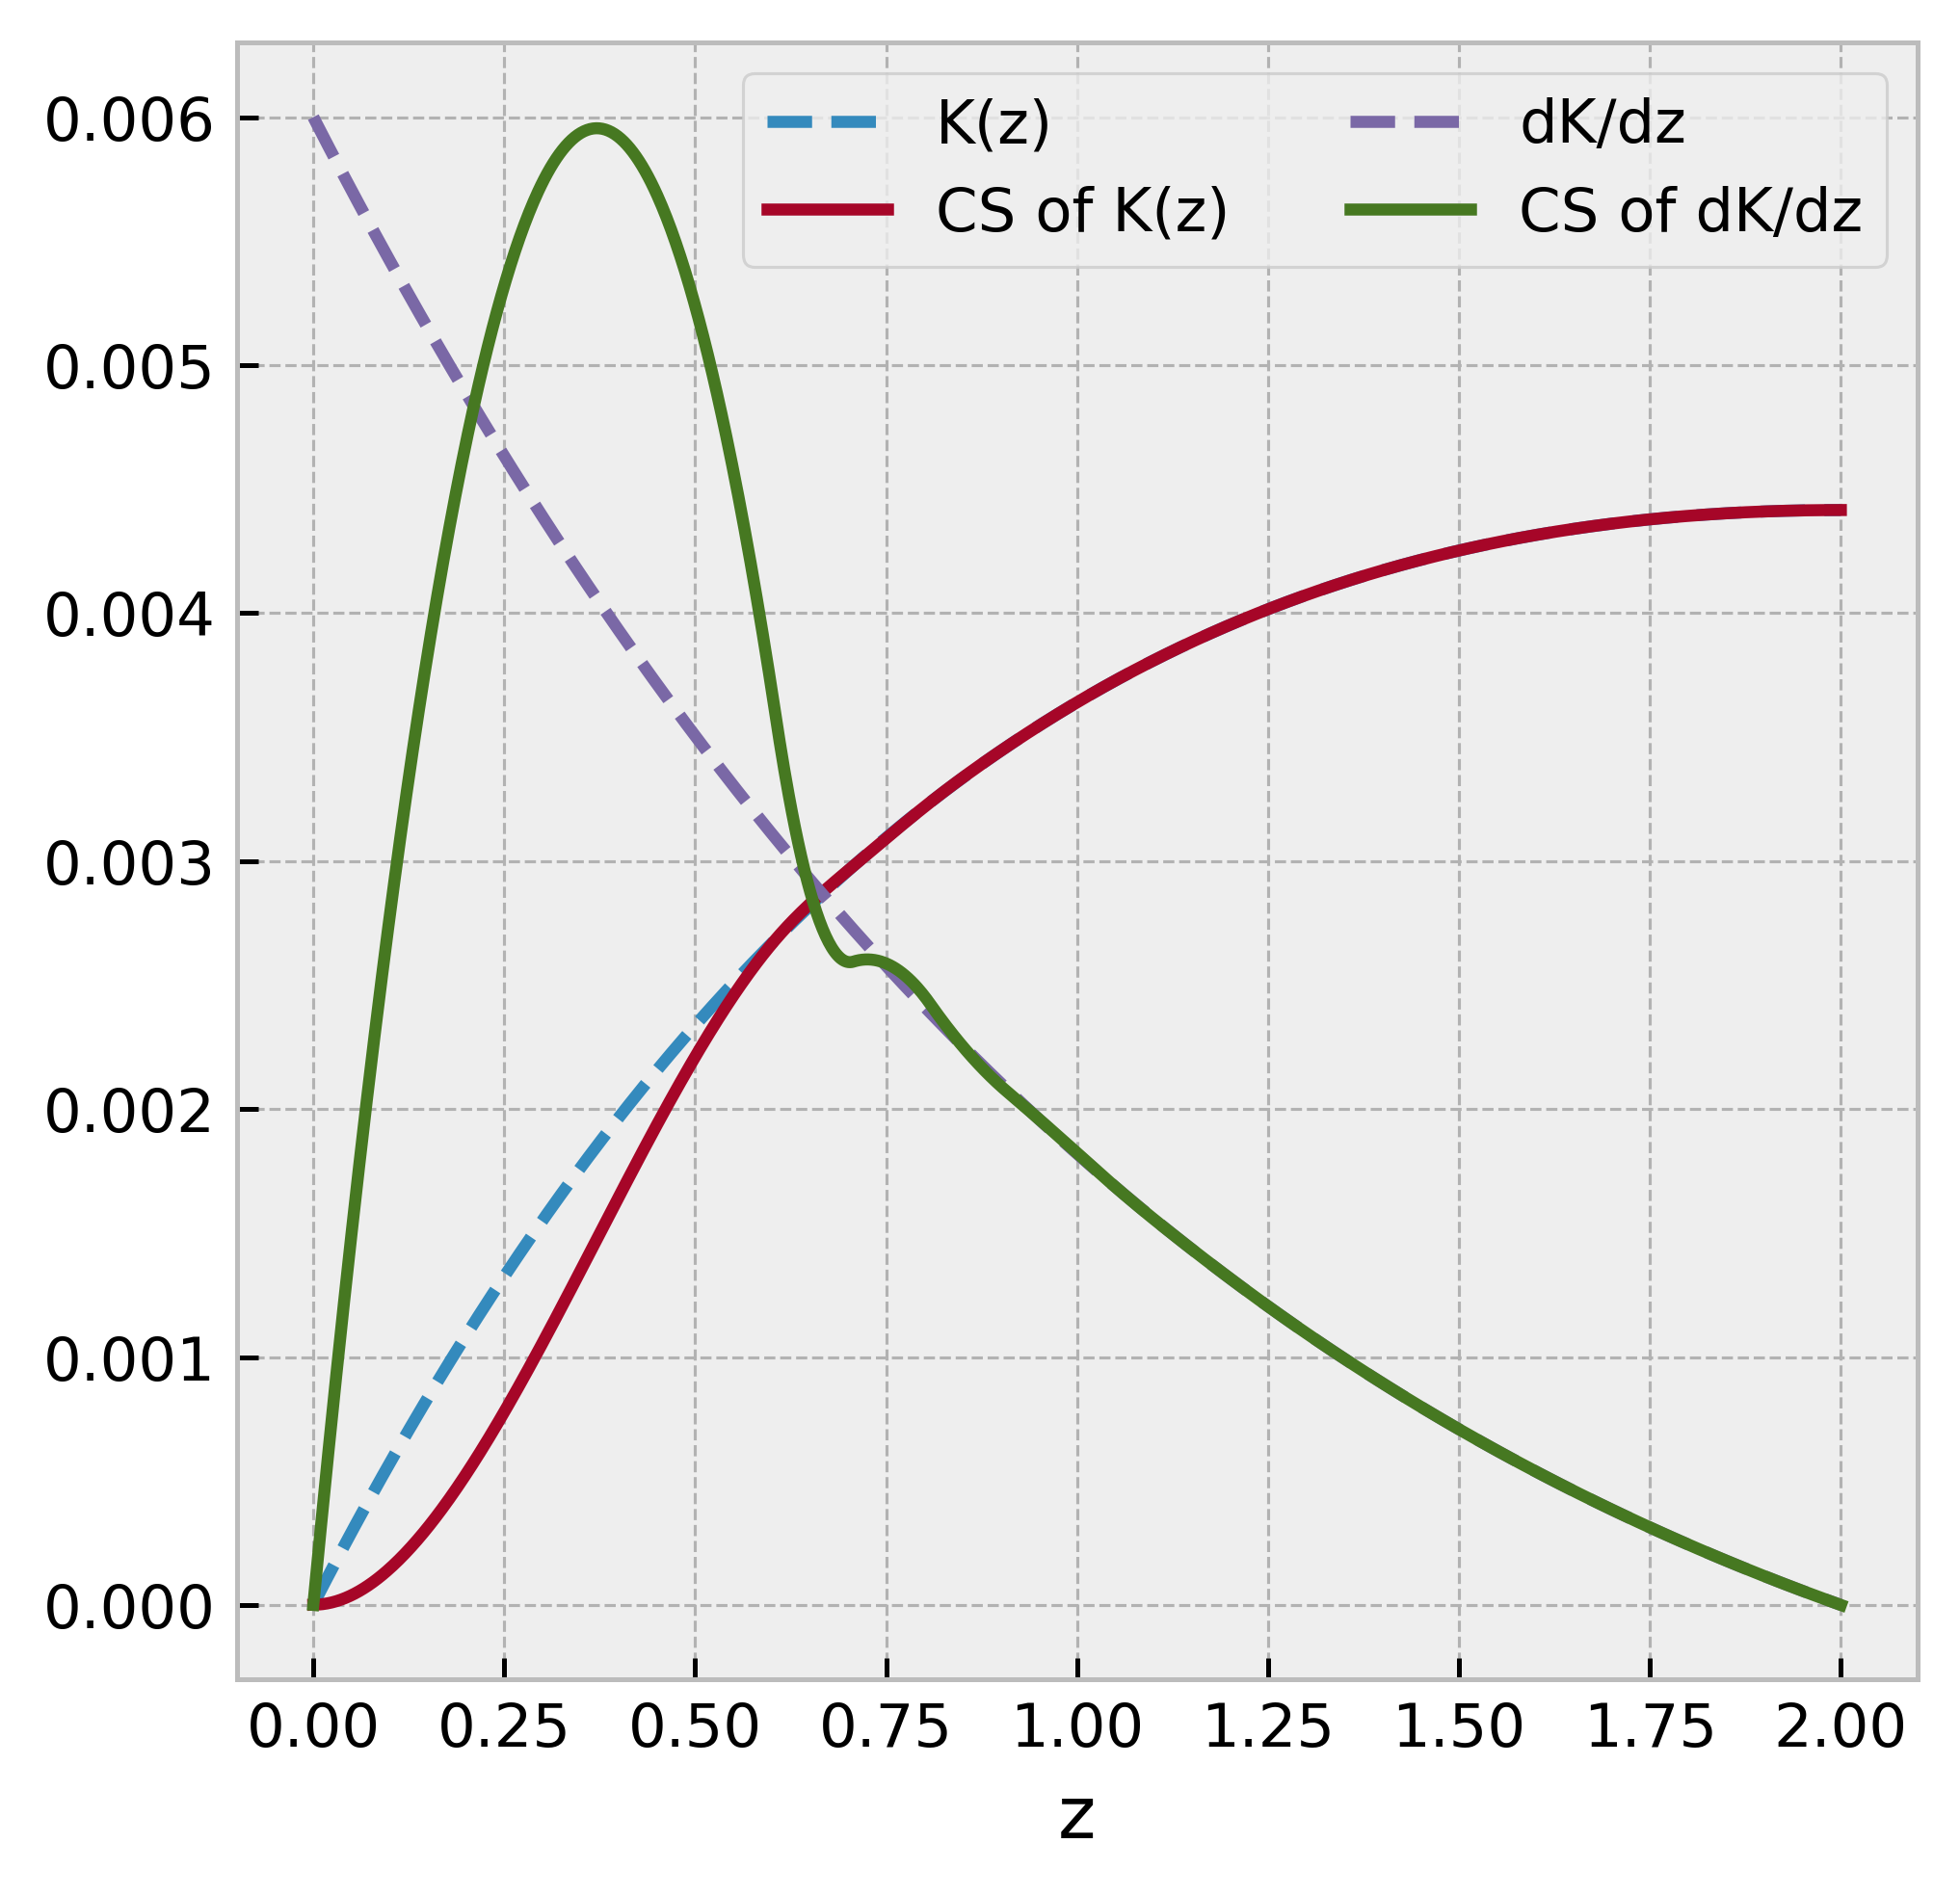

31.165164521790892


In [7]:
# Making spline and their function

%matplotlib inline
x = np.linspace(0, 10, 100)

delete = 5
for i in range(delete):
    x = np.delete(x, 1)
y = Diffu(x)

y[0] = K0

cs = CubicSpline(x, y, bc_type = "clamped", extrapolate= True)
xs = np.linspace(0, 2, 1000)

plt.figure( figsize=(5, 5) , dpi = 450)
plt.plot(xs, Diffu(xs), "--", label='K(z)')
plt.plot(xs, cs(xs), label="CS of K(z)")
plt.plot(xs, dKdz(xs),  "--", label="dK/dz")
plt.plot(xs, cs(xs, 1), label="CS of dK/dz")
#plt.plot(xs, cs(xs, 2), label="S''")
#plt.plot(xs, cs(xs, 3), label="S'''")
#plt.xlim(-0.001, 10)
plt.xlabel("z")
plt.legend(ncol=2)
#plt.xlim(0, 0.00005)
#plt.ylim(-0.0000003, 0.000002)
plt.show()

temp = np.absolute(cs(xs,2))
print(1/(np.max(temp)))

In [8]:
# SDE scheme using Cubic spline

def step_eCS(z,H,dt,N_sample):
    
    dW = np.random.normal(0,np.sqrt(dt),N_sample)
    
    a = cs(z, 1)
    b = np.sqrt(2*cs(z))
    
    temp=z+a*dt+b*dW
    
    return temp

def step_vCS(z,H,dt,N_sample):
    
    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    #Wiener process
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    a = cs(z, 1)
    G= cs(z+a*dt/2)
    
    temp= z + a*dt + np.sqrt(2/r*dt*G)*dW
    return temp

def step_mCS(z,H,dt,N_sample):
    
    dW = np.random.normal(0,np.sqrt(dt),N_sample)
    
    a = cs(z, 1)
    b = np.sqrt(2*cs(z))
    
    temp=z+1/2*a*(dt + dW**2)+b*dW
    
    return temp

def step_m2CS(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=cs(z)
    dkdz=cs(z, 1)
    ddkdz=cs(z, 2)
    dddkdz=cs(z, 3)
    sqrt2k=np.sqrt(2*k)
    
    a=dkdz
    da=ddkdz
    dda=dddkdz
    b= sqrt2k 
    db=dkdz/b
    ddb=ddkdz/b - ((dkdz)**2)/b**3
    ab=da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2
    
    return temp

## Testing E1

Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4


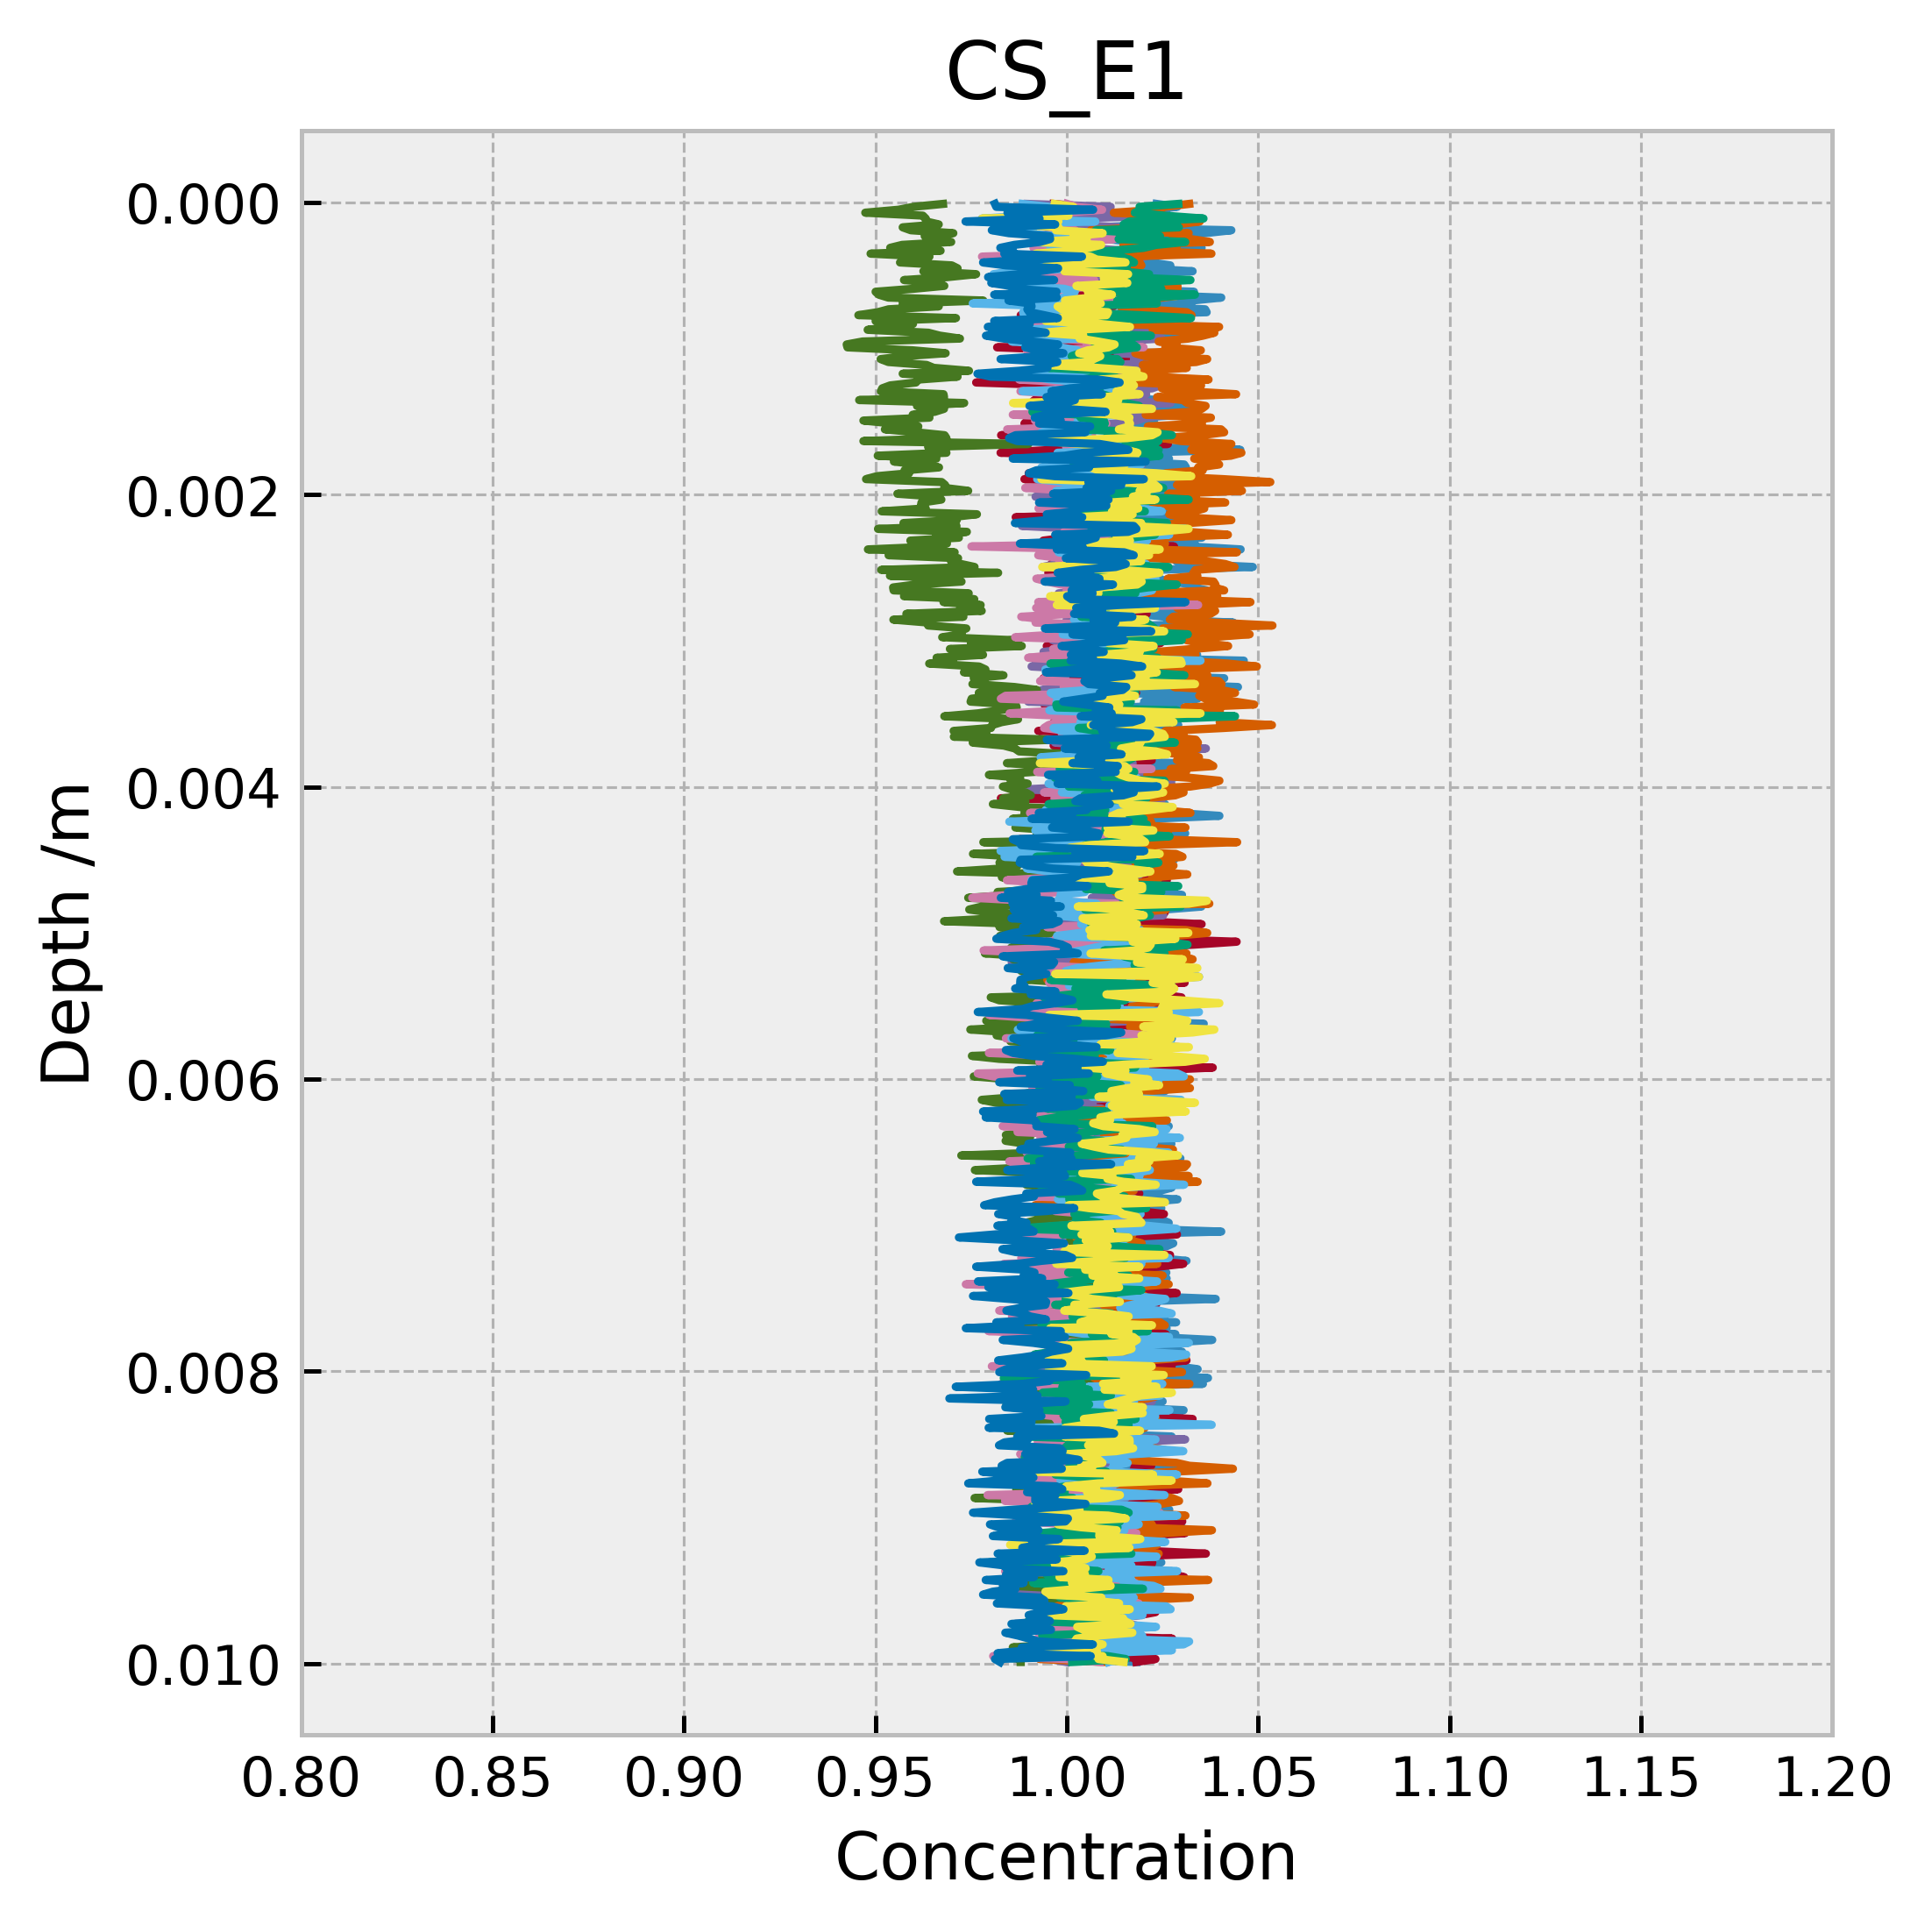

In [15]:
#
Np = 20000
Nbins = 500
dt = 0.05
Tmax = 1 * 3600
H = 2
Testdepth = 0.01
NumberOfThread = 4

Test = 10
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharey=True, dpi = 450)
ax.invert_yaxis()
for i in range(Test):
    EM_CS1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                            Np, Nbins, step_eCS)
    ax.plot(EM_CS1, midpoints, linewidth=1.5, label="")
    ax.set_xlabel('Concentration')
    ax.set_ylabel('Depth /m')
    ax.set_title('CS_E1')
    ax.set_xlim(0.8, 1.2)
    plt.tight_layout()
plt.show()

In [16]:
Np = 20000
Nbins = 1000
dt = 0.05
Tmax = 3 * 3600
H = 2
Testdepth = 0.01
NumberOfThread = 4

print("Tmax :", Tmax / 60, " minutes")
print("Loop :", Tmax / 0.05)

EM_CS_near1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                        Np, Nbins, step_eCS)
EM_near1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                        Np, Nbins, step_e)


Tmax : 180.0  minutes
Loop : 216000.0
Total number of process:  4
Total number of process:  4


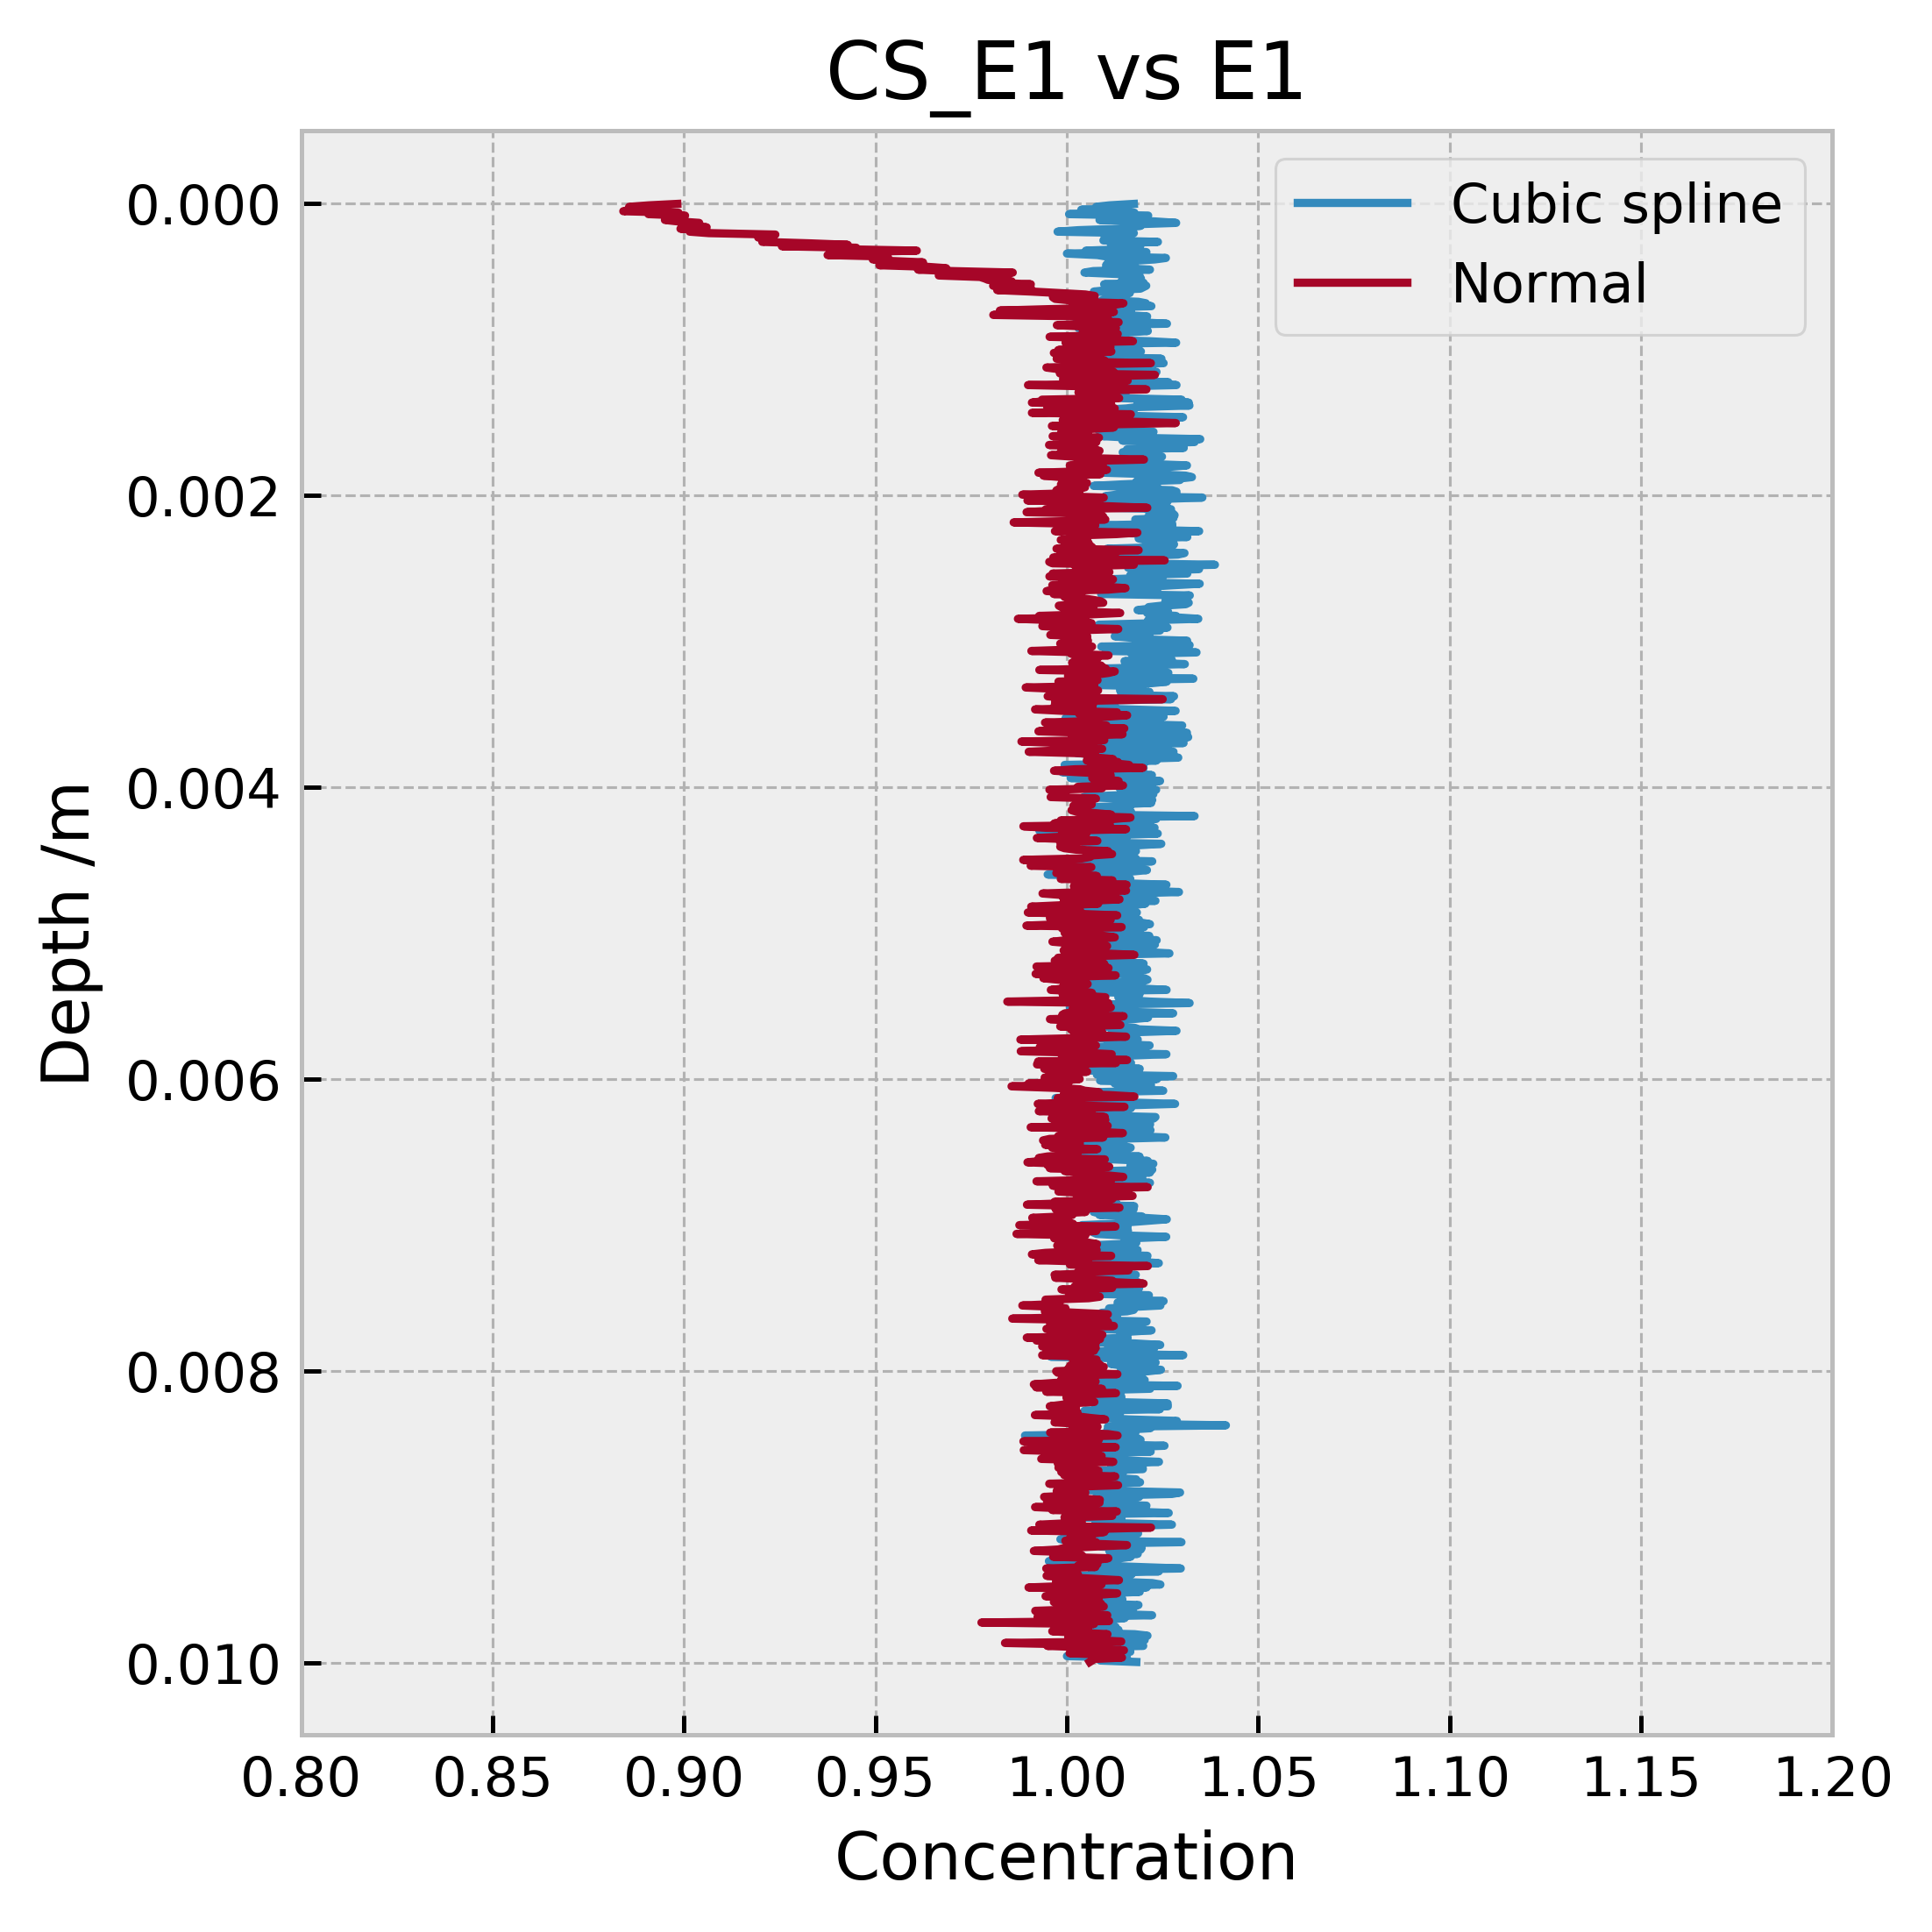

In [17]:
#
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharey=True, dpi = 450)
ax.plot(EM_CS_near1, midpoints, linewidth=1.5, label="Cubic spline")
ax.plot(EM_near1, midpoints, linewidth=1.5, label="Normal")
ax.set_xlabel('Concentration')
ax.set_ylabel('Depth /m')
ax.set_title('CS_E1 vs E1')
ax.set_xlim(0.8, 1.2)
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Testing V1

In [18]:
Np = 20000
Nbins = 1000
dt = 0.05
Tmax = 3 * 3600
H = 2
Testdepth = 0.01
NumberOfThread = 4

print("Tmax :", Tmax / 60, " minutes")
print("Loop :", Tmax / 0.05)

V1_CS_near1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                        Np, Nbins, step_vCS)

V1_near1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                        Np, Nbins, step_v)

Tmax : 180.0  minutes
Loop : 216000.0
Total number of process:  4
Total number of process:  4


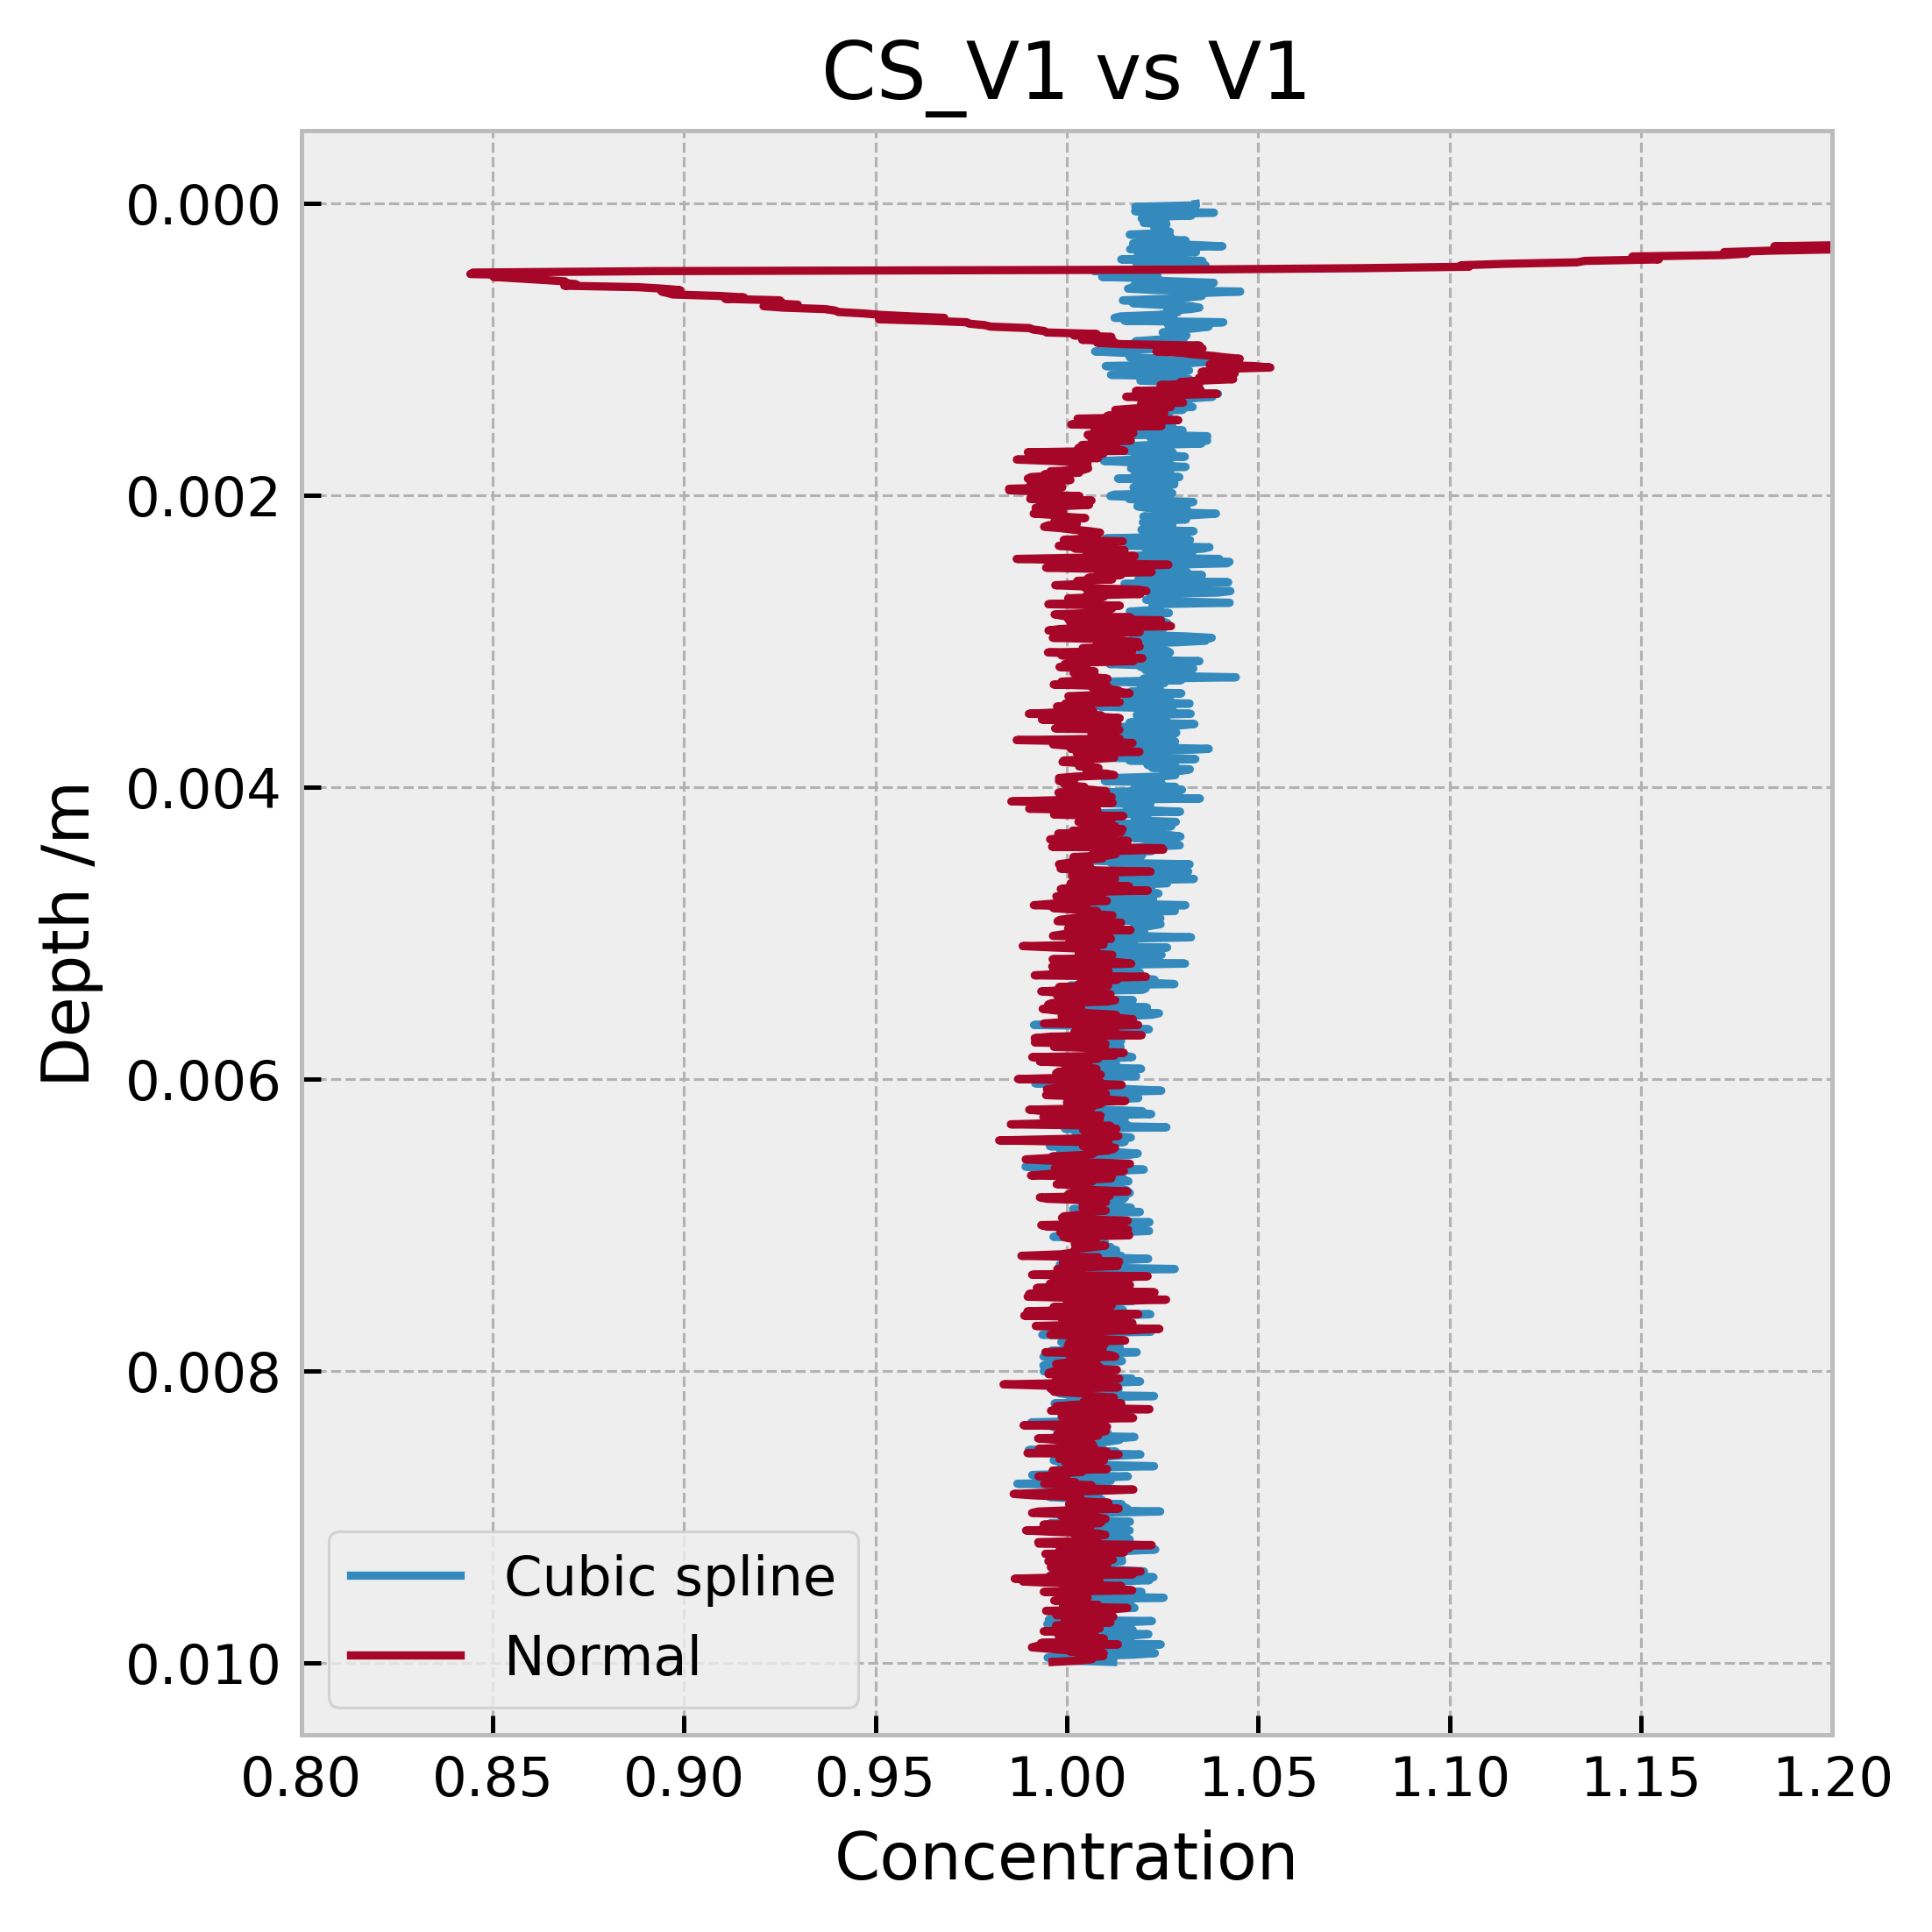

In [19]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharey=True, dpi = 450)
ax.plot(V1_CS_near1, midpoints, linewidth=1.5, label="Cubic spline")
ax.plot(V1_near1, midpoints, linewidth=1.5, label="Normal")
ax.set_xlabel('Concentration')
ax.set_ylabel('Depth /m')
ax.set_title('CS_V1 vs V1')
ax.set_xlim(0.8, 1.2)
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Testing M1

In [20]:
Np = 20000
Nbins = 1000
dt = 0.05
Tmax = 3 * 3600
H = 2
Testdepth = 0.01
NumberOfThread = 4

print("Tmax :", Tmax / 60, " minutes")
print("Loop :", Tmax / 0.05)

M1_CS_near1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                        Np, Nbins, step_mCS)

M1_near1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                        Np, Nbins, step_m)

Tmax : 180.0  minutes
Loop : 216000.0
Total number of process:  4
Total number of process:  4


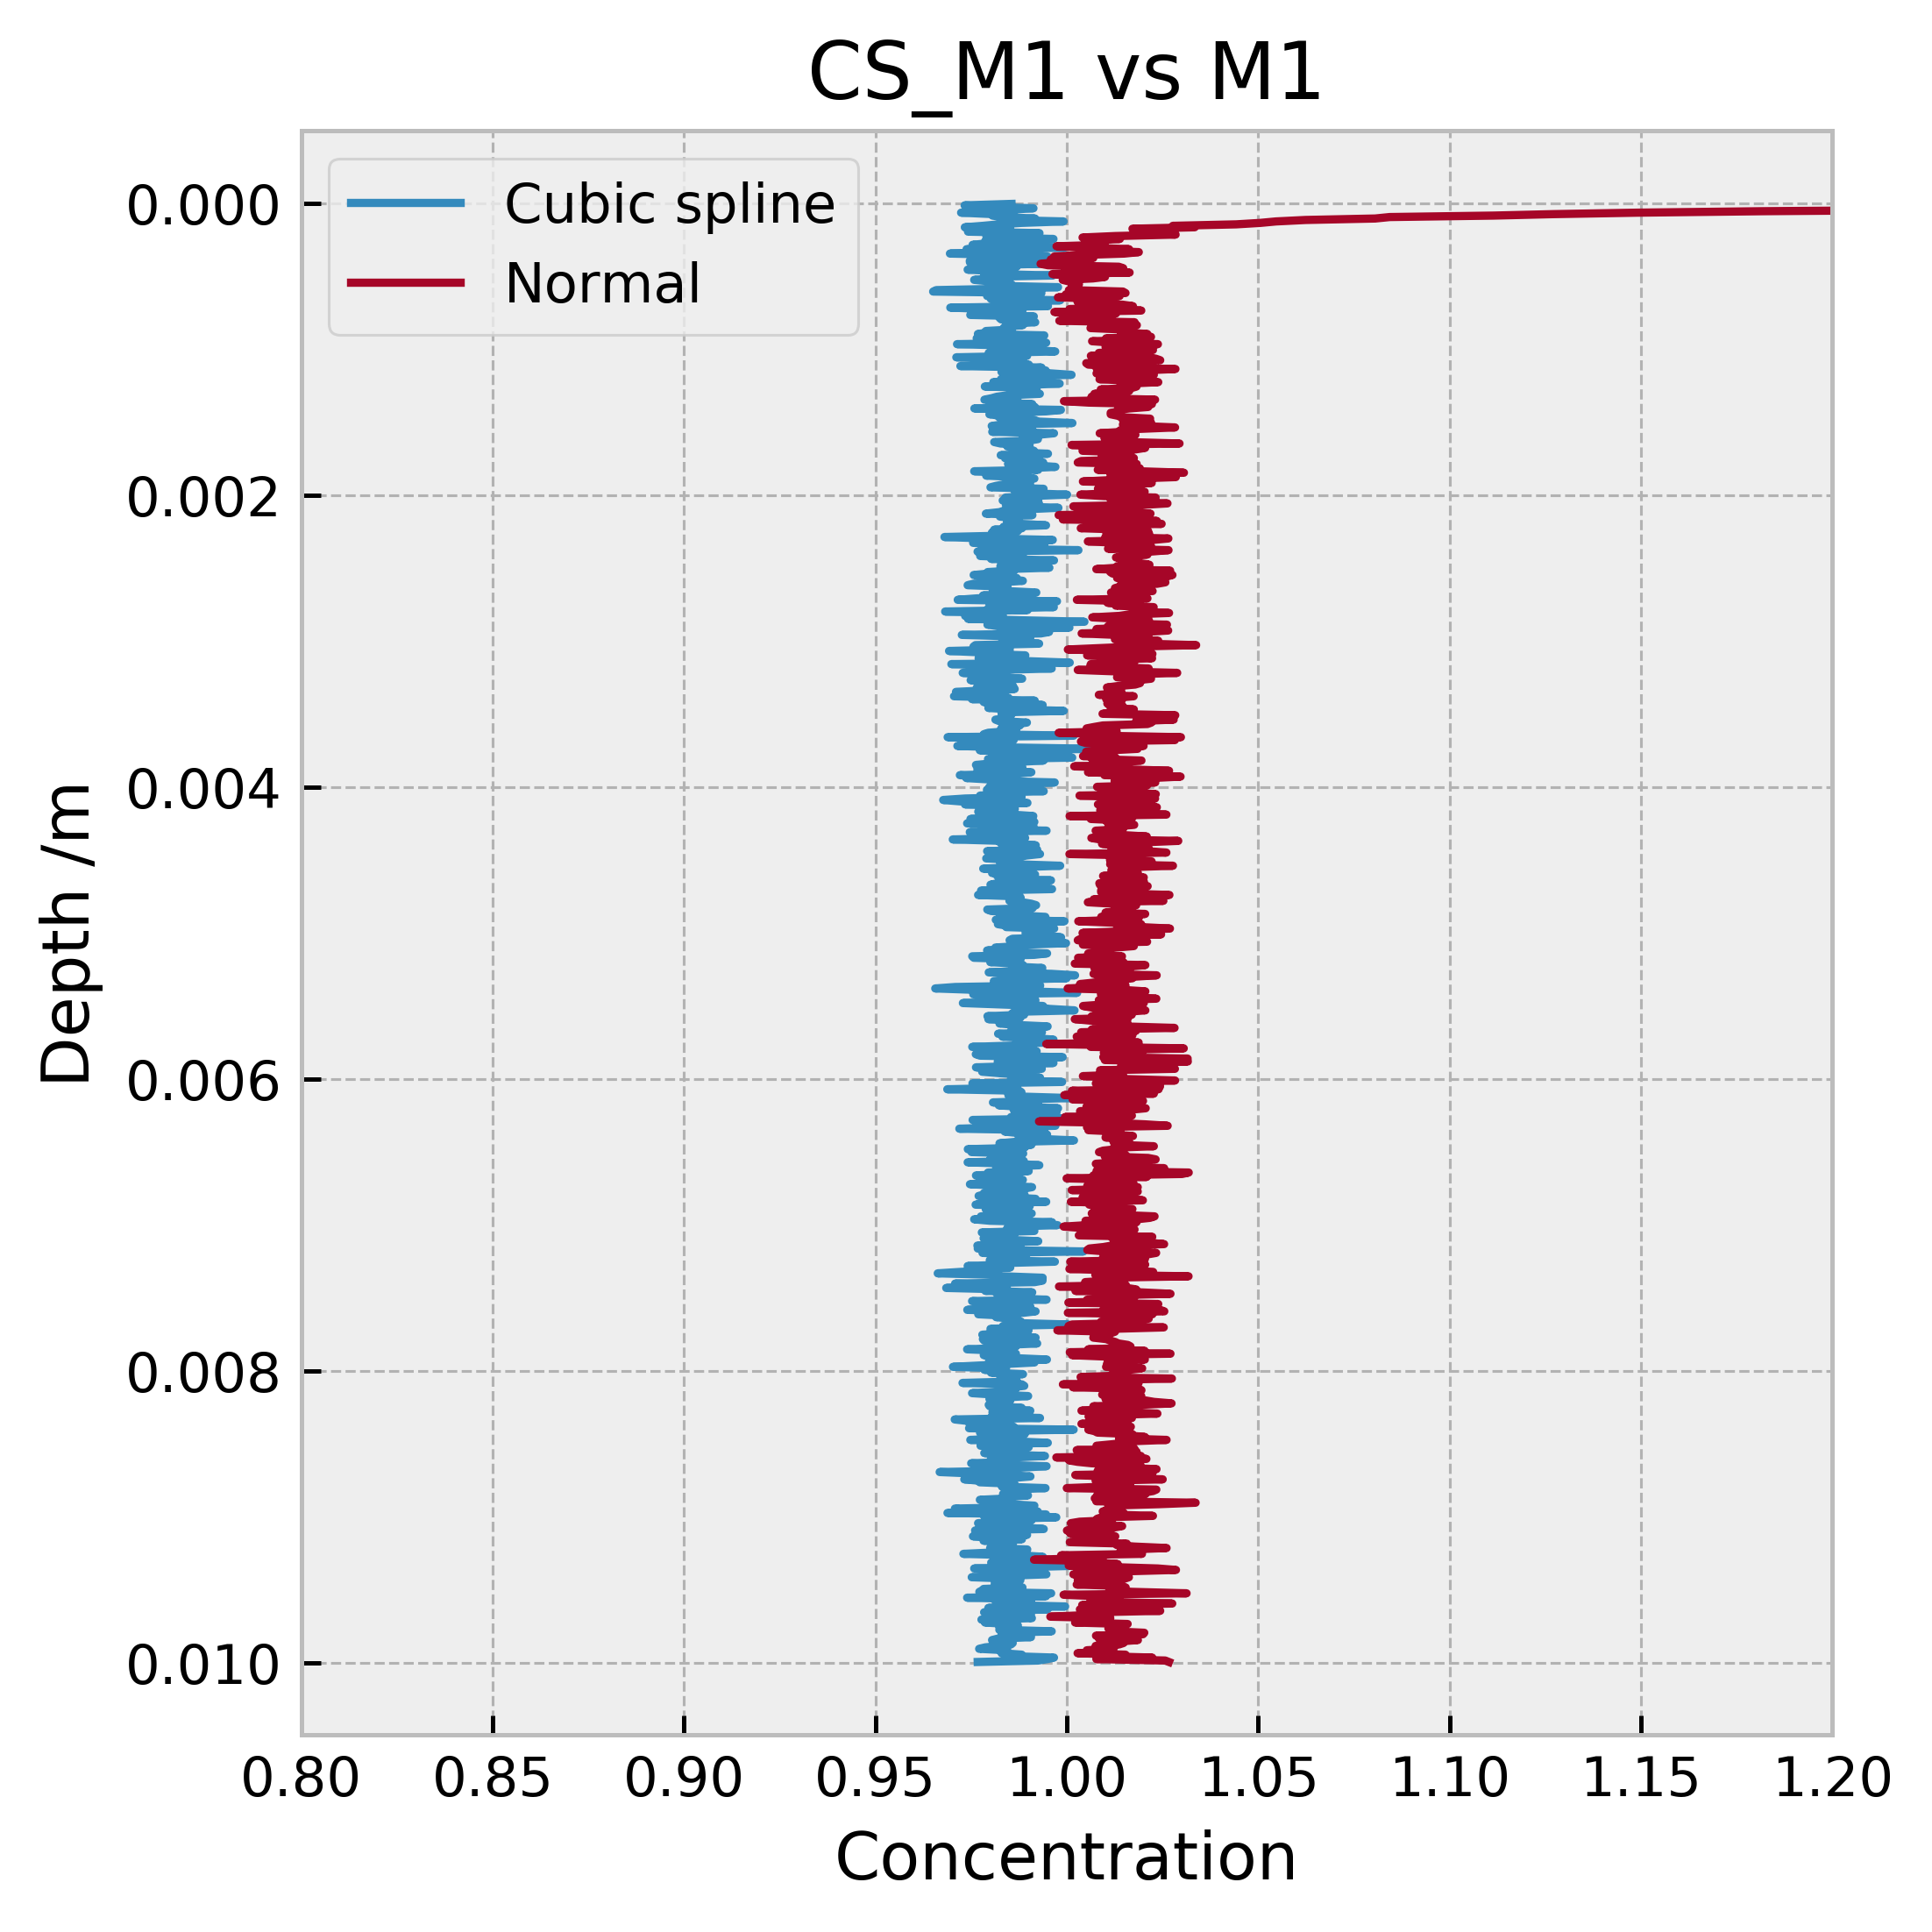

In [21]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharey=True, dpi = 450)
ax.plot(M1_CS_near1, midpoints, linewidth=1.5, label="Cubic spline")
ax.plot(M1_near1, midpoints, linewidth=1.5, label="Normal")
ax.set_xlabel('Concentration')
ax.set_ylabel('Depth /m')
ax.set_title('CS_M1 vs M1')
ax.set_xlim(0.8, 1.2)
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Testing M2

In [10]:
Np = 20000
Nbins = 1000
dt = 0.05
Tmax = 3 * 3600
H = 2
Testdepth = 0.01
NumberOfThread = 4

print("Tmax :", Tmax / 60, " minutes")
print("Loop :", Tmax / 0.05)

M2_CS_near1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                        Np, Nbins, step_m2CS)

M2_near1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth,
                                        Np, Nbins, step_m2)

Tmax : 180.0  minutes
Loop : 216000.0
Total number of process:  4
Total number of process:  4


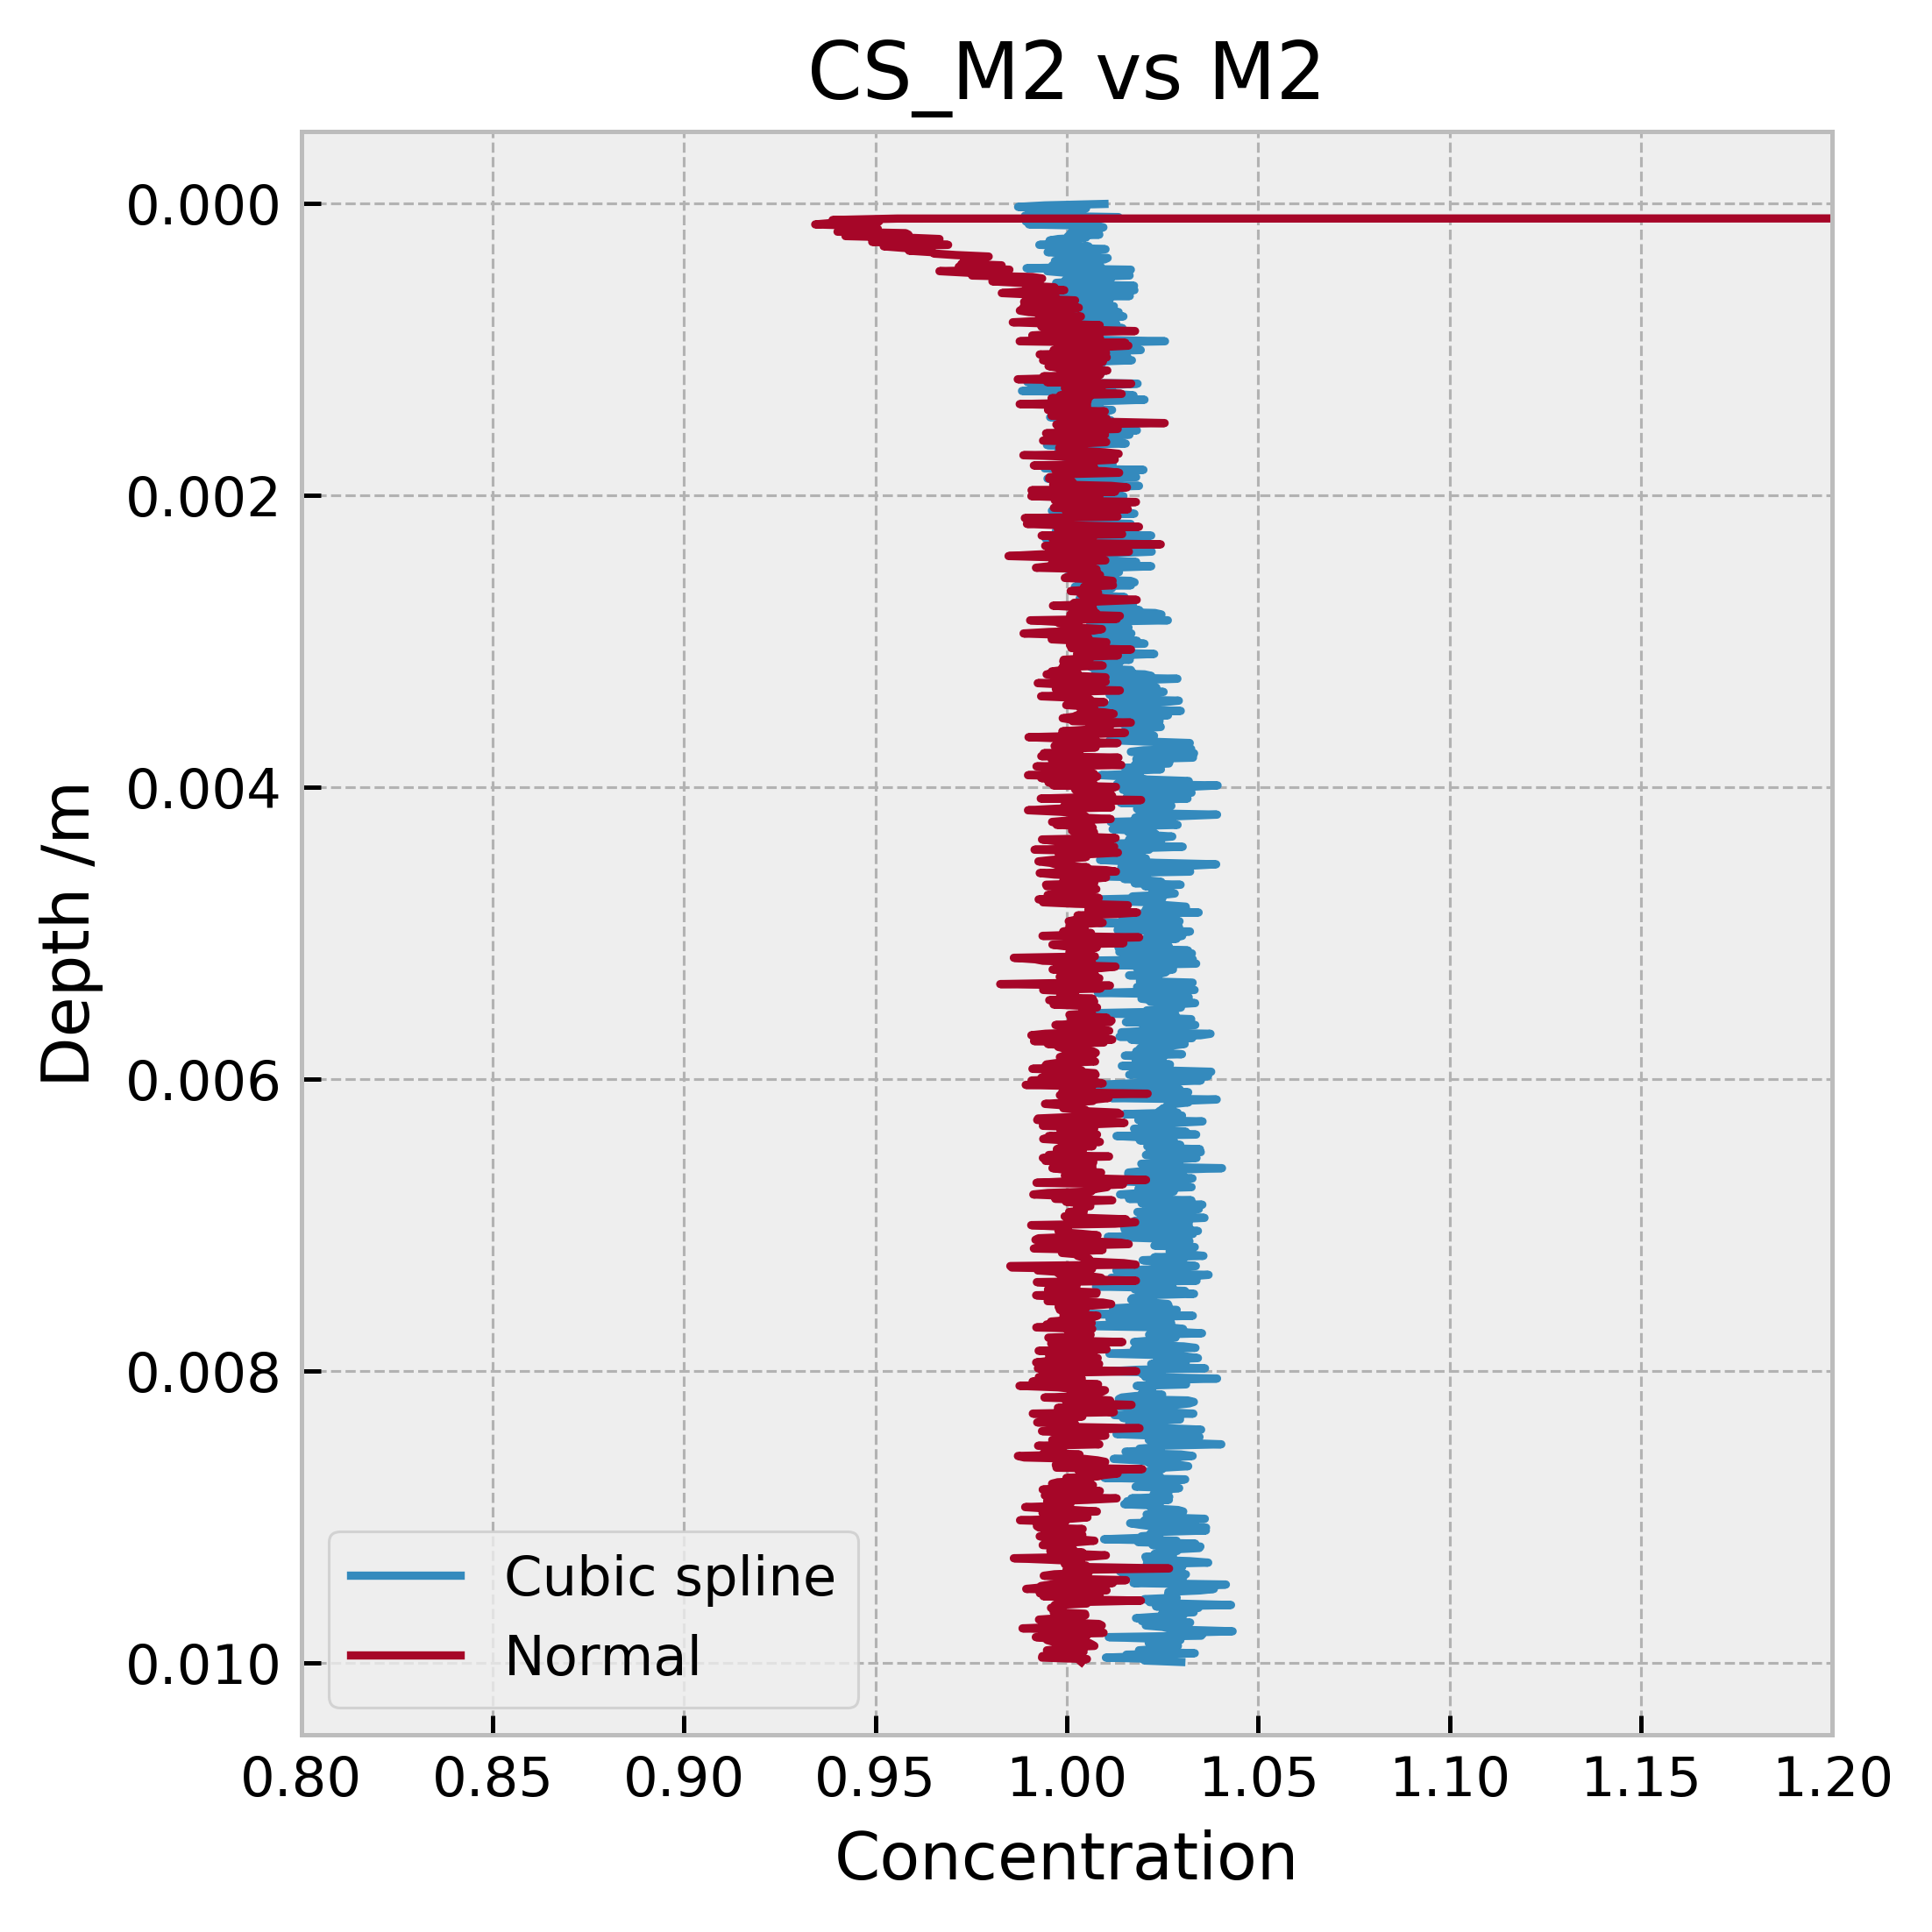

In [11]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2

fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharey=True, dpi = 450)
ax.plot(M2_CS_near1, midpoints, linewidth=1.5, label="Cubic spline")
ax.plot(M2_near1, midpoints, linewidth=1.5, label="Normal")
ax.set_xlabel('Concentration')
ax.set_ylabel('Depth /m')
ax.set_title('CS_M2 vs M2')
ax.set_xlim(0.8, 1.2)
ax.legend()

ax.invert_yaxis()
plt.tight_layout()
plt.show()

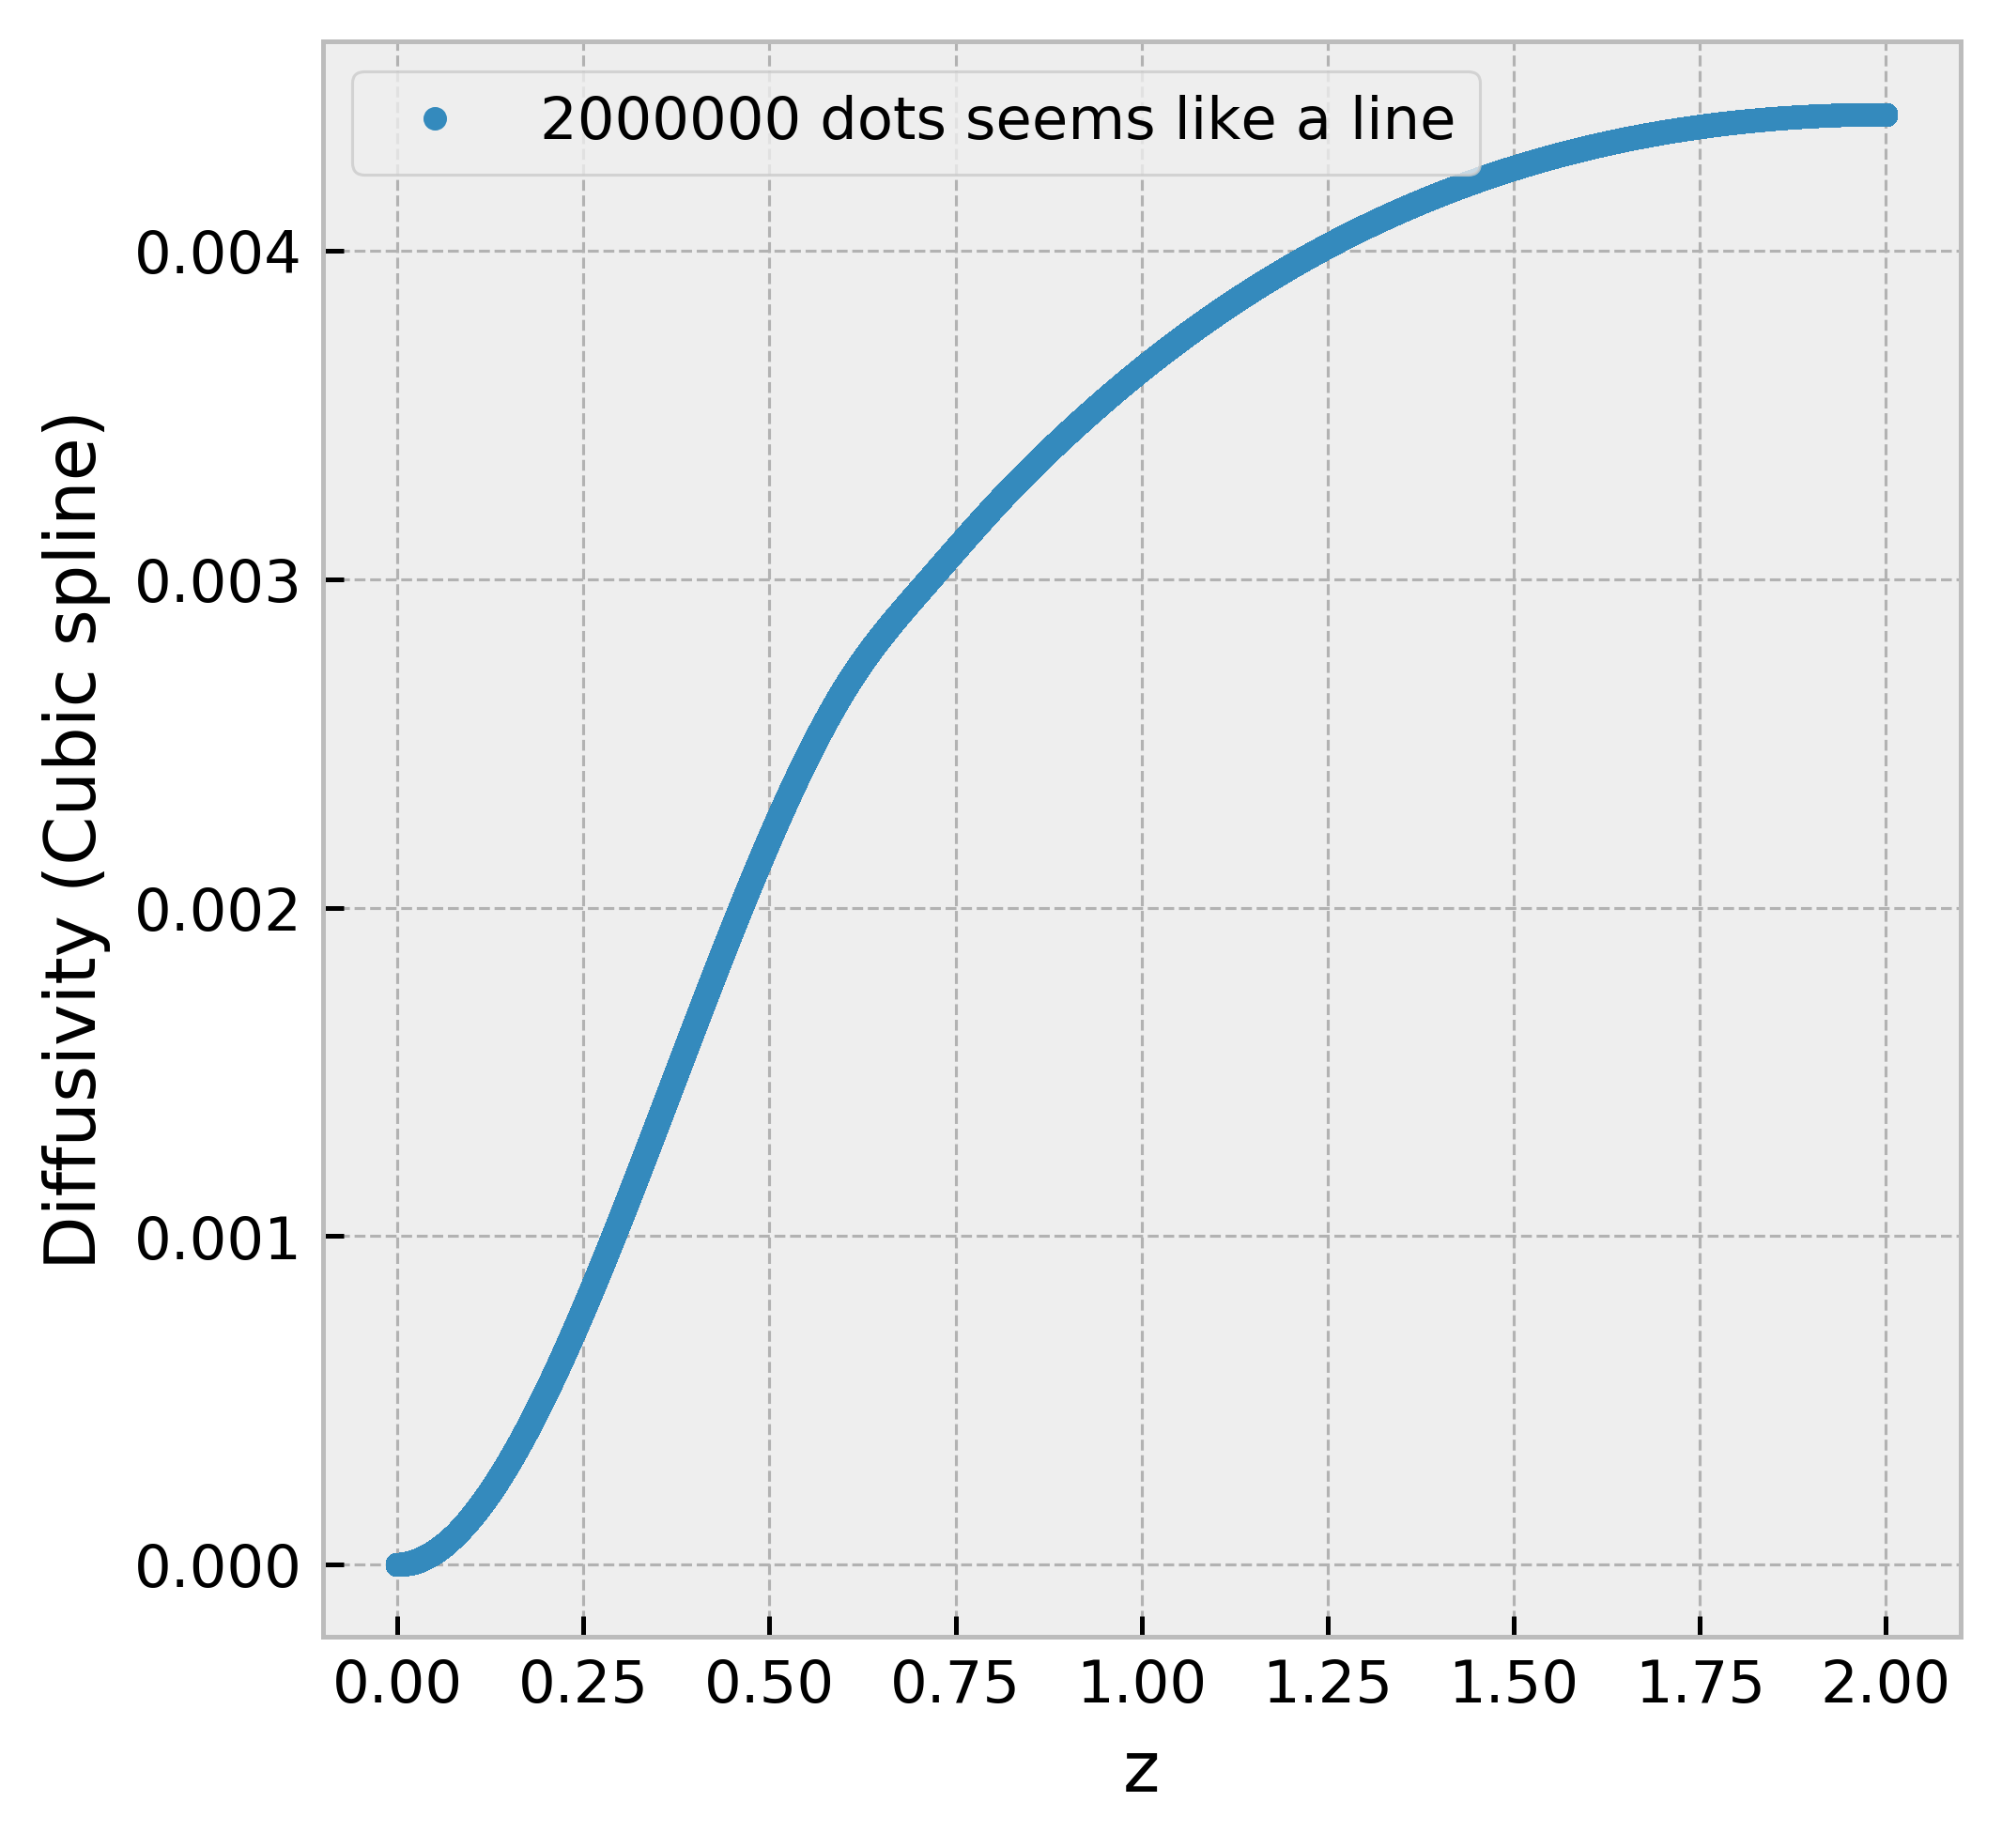

In [29]:
z = np.random.uniform(0, 2, 2000000)
plt.figure(figsize=(5,5), dpi = 450) 
plt.plot(z, cs(z), ".", label ="2000000 dots seems like a line")
plt.xlabel("z")
plt.ylabel("Diffusivity (Cubic spline)")
plt.legend()

In [27]:
import os
duration = 1  # seconds
freq = 1440  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

0

In [ ]:
# Junk

Np = 200000
Nbins = 1000
dt = 0.05
Tmax = dt * 1 * 3600
H = 2
Testdepth = 0.2
NumberOfThread = 4

Test = 1

fig, ax = plt.subplots(ncols=3, figsize=(11.69, 8), sharey=True)
ax[0].invert_yaxis()
for i in range(Test):
    EM_CS1, EM_CS2, EM_CS3 = RunSimulation2(NumberOfThread, Tmax, dt, H,
                                            Testdepth, Np, Nbins, step_eCS)
    bins = np.linspace(0, Testdepth, Nbins)
    midpoints = bins[:-1] + (bins[1] - bins[0]) / 2

    ax[0].plot(EM_CS1, midpoints, linewidth=1.5, label="variable")
    ax[0].set_xlabel('Concentration')
    ax[0].set_ylabel('Depth /m')
    ax[0].set_title('CS_EM')
    ax[0].set_xlim(0.8, 1.2)
    ax[0].legend()
    ax[1].plot(EM_CS2, midpoints, linewidth=1.5, label="variable")
    ax[2].plot(EM_CS3, midpoints, linewidth=1.5, label="variable")
    plt.tight_layout()
plt.show()

EM_Ori1, EM_Ori2, EM_Ori3 = RunSimulation2(NumberOfThread, Tmax, dt, H,
                                           Testdepth, Np, Nbins, step_e)
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1] - bins[0]) / 2
fig, ax = plt.subplots(ncols=3, figsize=(11.69, 8), sharey=True)
ax[0].plot(EM_Ori1, midpoints, linewidth=1.5, label="variable")
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('EM')
ax[0].invert_yaxis()
ax[0].set_xlim(0.7, 1.3)
ax[0].legend()
ax[1].plot(EM_Ori2, midpoints, linewidth=1.5, label="variable")
ax[2].plot(EM_Ori3, midpoints, linewidth=1.5, label="variable")
plt.tight_layout()